# HW6: Neural Network with Pytorch
By **Dr. Fardina Alam**
Due Date: December 06, 2024

In the class, I have already shared some pytorch code for building neural network- the process of building, training, and optimizing neural network models in PyTorch, enabling you to transform data into actionable intelligence.

In this homework, the aim is to introduce you to "[PyTorch Lightning](https://lightning.ai/docs/pytorch/stable/)" which is the deep learning framework for professional AI researchers and machine learning engineers who need maximal flexibility without sacrificing performance at scale.


Here is a good artcile - "https://towardsdatascience.com/from-pytorch-to-pytorch-lightning-a-gentle-introduction-b371b7caaf09"


**About this Notebook File:**
For this homework, you will work with MNIST dataset using PyTorch Lightning! In this session, you will construct both a Feedforward Neural Network and a Convolutional Neural Network. You will be implementing and evaluating multiple learning methods for training deep neural networks on the MNIST digit recognition dataset using a machine learning framework.

About the Dataset:

The MNIST dataset is perhaps the most popular dataset used with machine learning, especially in small "toy" applications or demonstrations. The goal of the MNIST dataset is to predict what digit is represented by an image of a hand-written digit. It has 60000 training examples, and 10000 test examples, each of which is a 28×28 a grayscale image representing one of the 10 digits.


You can import this dataset from Pytorch directly "https://pytorch.org/vision/main/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST"


SOME SAMPLE CODE ARE ALREADY PROVIDED LAST CLASS FOR NEURAL NETWORK.






In [1]:
# Run this code if you have not installed it already. If you are running on your PC directly, creating Python Virtual Envioronemnt is recommendable.
!pip install pytorch-lightning

## Importing Necessary Python Libraries

Let's start by importing all the essential libraries required for this tutorial. These libraries will help us build and train our deep learning models on the MNIST dataset.

In [2]:
# Feel free to import more libraries if needed.
import torch
from torch import nn
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from pytorch_lightning import Trainer
import time
import matplotlib.pyplot as plt
from torchmetrics.classification import Accuracy
from pytorch_lightning import Trainer
import torch.optim as optim

#Part 0: Identifying a Neural Network from the literature. (Points 08)
One of the first successful neural networks for MNIST was **LeNet-5** (main paper and relavent papers are available in online). By doing a literature search, answer the following questions, and present your findings in your report.

*   What is the paper in which LeNet-5 was first proposed? (point: 1)
*   What is architecture of LeNet-5? That is, what layers does it have, how large are they, how are they connected, and what activation function is used?  (point: 3)
* What accuracy should one expect to get when implementing LeNet-5 on MNIST? That is, what accuacy was achieved in previous work?  (point: 2)
* What training algorithm was used to (point: 2)

Your answer

- LeNet-5 was first proposed in the paper "Gradient-Based Learning Applied to Document Recognition" by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner.

- LeNet-5 Architecture

    - Input: The input is a 32x32 pixel image of a handwritten character. The input pixel values are normalized so that the background is -0.1 and the foreground is 1.1.

    - Layer C1 (Convolutional): This layer has 6 feature maps, with each unit connected to a 5x5 neighborhood in the input.

    - Layer S2 (Sub-sampling): This layer has 6 feature maps of size 14x14. Each unit is connected to a 2x2 neighborhood in the corresponding feature map in C1.

    - Layer C3 (Convolutional): This layer has 16 feature maps of size 10x10. Each unit is connected to a 5x5 neighborhood in S2, with connections to multiple feature maps in S2.

    - Layer S4 (Sub-sampling): This layer has 16 feature maps of size 5x5, with each unit connected to a 2x2 neighborhood in the corresponding feature map in C3.

    - Layer C5 (Convolutional): This layer has 120 feature maps. Each unit is connected to a 5x5 neighborhood in S4. Because the size of S4 is 5x5, this layer has a full connection between S4 and C5.

    - Layer F6 (Fully Connected): This layer has 84 units and is fully connected to C5.

    - Output (10 units): The output layer has 10 units, one for each digit class. The activation function used in LeNet-5 is hyperbolic tangent.

- LeNet-5 achieved an error rate of 0.8% on the MNIST test set when trained with distorted images. When trained without distorted images, it achieved a test error rate of 0.95%.


- LeNet-5 was trained using a stochastic diagonal Levenberg-Marquardt method.

# Part 1: Data Dowload, Transformation, Train-Validation-Test Split (Points 08)

Use a train/validation split with **10%** of the training data assigned randomly to the validation set.

In [3]:
# Transformations to apply to the data (e.g., normalization)
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

# Download MNIST dataset
train_dataset = datasets.MNIST(root="dataset/", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="dataset/", train=False, transform=transform, download=True)

# random split the training dataset into 90% training and 10% validation
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training, validation, and test datasets
batch_size = 32
train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

A Sample Code for "Plot Accuracy" is provided. If you want you can change the code or use the below code.

In [4]:
#run it

def plot_Accuracy(model):
      # Ensure data exists in the lists
      if not model._train_acc or not model._val_acc:
          print("No accuracy data found to plot.")
          return

      # Create the plot
      plt.figure(figsize=(10, 6))

      # Plot training and validation accuracy
      plt.plot(model._train_acc, label="Train Accuracy", color='blue', marker='o')
      plt.plot(model._val_acc, label="Validation Accuracy", color='green', marker='x')

      # Last training and validation epoch index
      last_train_epoch = len(model._train_acc) - 1
      last_val_epoch = len(model._val_acc) - 1

      # Display final accuracies at the last epoch
      plt.axvline(x=last_train_epoch, color='r', linestyle='--',
                  label=f"Final Train Accuracy: {model._train_acc[last_train_epoch]:.4f}")
      plt.axvline(x=last_val_epoch, color='g', linestyle='--',
                  label=f"Final Validation Accuracy: {model._val_acc[last_val_epoch]:.4f}")

      # If test accuracy exists, plot it after the last training epoch
      if model.test_acc_value is not None:
          # Test accuracy is shown after the last training epoch (post-training)
          plt.axvline(x=last_train_epoch + 1, color='b', linestyle='--',
                      label=f"Test Accuracy: {model.test_acc_value:.4f}")

      # Add labels, title, and legend
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title('Training, Validation, and Test Accuracy')
      plt.legend(loc='best')

      # Add grid lines for better readability
      plt.grid(True)

      # Adjust layout and show the plot
      plt.tight_layout()
      plt.show()


# Part 2.1: Training a FeedForwad Neural Network (Points 18)

We want to explore a simple feedforward network first.

In PyTorch Lightning, implement a feedforward neural network with the following layers:

* Input: 28×28 (784-dimensional vector).
* First Hidden Layer: Fully connected layer with 128 neurons, followed by ReLU activation.
* Second Hidden Layer: Fully connected layer with 64 neurons, followed by ReLU activation.
* Third Hidden Layer: Fully connected layer with 32 neurons, followed by ReLU activation.
* Output Layer: Fully connected layer with 10 neurons (logits), no activation applied here, as CrossEntropyLoss will handle the softmax.


**Training Details:**

* Train this network using a categorical cross-entropy loss with the following hyperparameters.
* Use the default initialization for your ML framework.
* Run stochastic gradient descent with momentum, using a step size of α= 0.001, a momentum parameter of β=0.99, and a minibatch size of B=32 . (These are mostly just default values for neural network training, and not chosen with much intelligence or tuning.)
* Run for 5 epochs. (That is, 5 passes through the training data.)

Before training and after each epoch (i.e. a total of 6 times), measure the following: *The training loss. *The training error. *The validation error.


Plot these observed values (on a figure with iterations on the x-axis) and include the resulting figures in your report.

Also measure the amount of wall-clock time bold text it took to train this model, and include this measurement in your report.


**Create the NN class (Points 10)**

In [5]:
class SimpleFFNN(pl.LightningModule):
    def __init__(self):
        super(SimpleFFNN, self).__init__()

        # Define a simple feedforward network
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 10)
        self.loss_fn = nn.CrossEntropyLoss()

        # Define activation function
        self.relu = nn.ReLU()

        # Initialize Accuracy metrics for multiclass classification
        self.train_acc = Accuracy(task='MULTICLASS', num_classes=10) # modify your code
        self.val_acc = Accuracy(task='MULTICLASS', num_classes=10)
        self.test_acc = Accuracy(task='MULTICLASS', num_classes=10)

        # Use these lists to store values for plotting
        self._train_loss = []
        self._train_acc = []
        self._val_loss = []
        self._val_acc = []
        self.test_loss = None
        self.test_acc_value = None

    def forward(self, x):
        # Flatten the input for the fully connected layers
        x = x.view(x.size(0), -1)

        #YOUR CODE
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

    def training_step(self, batch, batch_idx):
        # Training step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)  # Forward pass

        # Compute the cross-entropy loss
        loss = self.loss_fn(y_hat, y)

        # Calculate accuracy
        acc = self.train_acc(y_hat, y)

        # housekeeping
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'acc': acc}

    def on_train_epoch_end(self):
        # Collect training loss and accuracy at the end of the epoch: check trainer.callback_metrics
        avg_loss = self.trainer.callback_metrics.get('train_loss', None)
        avg_acc = self.trainer.callback_metrics.get('train_acc', None)

        if avg_loss is not None and avg_acc is not None:
            self._train_loss.append(avg_loss.item())
            self._train_acc.append(avg_acc.item())

    def validation_step(self, batch, batch_idx):
        # Validation step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        # Collect validation loss and accuracy at the end of the epoch
        avg_val_loss = self.trainer.callback_metrics.get('val_loss', None)
        avg_val_acc = self.trainer.callback_metrics.get('val_acc', None)

        if avg_val_loss is not None and avg_val_acc is not None:
            self._val_loss.append(avg_val_loss.item())
            self._val_acc.append(avg_val_acc.item())

    def test_step(self, batch, batch_idx):
        # Test step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)              # Correct usage of the test accuracy
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self):
        # Collect test loss and accuracy after testing
        avg_test_loss = self.trainer.callback_metrics.get('test_loss', None)
        avg_test_acc = self.trainer.callback_metrics.get('test_acc', None)

        if avg_test_loss is not None and avg_test_acc is not None:
            self.test_loss = avg_test_loss.item()
            self.test_acc_value = avg_test_acc.item()

    def configure_optimizers(self):
        # Use SGD optimizer with momentum and lr given above
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.99)
        return optimizer

**Train the FFNN model (Points 06)**

In [6]:
# Initialize the model
modelF = SimpleFFNN()

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code

# Measure wall-clock time
start_time = time.time()

# Train the model: use fit
trainer.fit(modelF, train_loader)
trainer.validate(modelF, val_loader)

# Measure training time
end_time = time.time()

training_time = end_time - start_time

# Print the training time
print(f"Training took {training_time:.2f} seconds.")

# Evaluate on test set
# Test the model after training
test_result= trainer.test(modelF, test_loader)
print(f"Test accuracy: {test_result[0]['test_acc']:.4f}")

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | fc1       | Linear             | 100 K  | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9599999785423279     │
│         val_loss          │    0.14974990487098694    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 134.00 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9591000080108643     │
│         test_loss         │    0.14122913777828217    │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9591


Plot (Points 02)

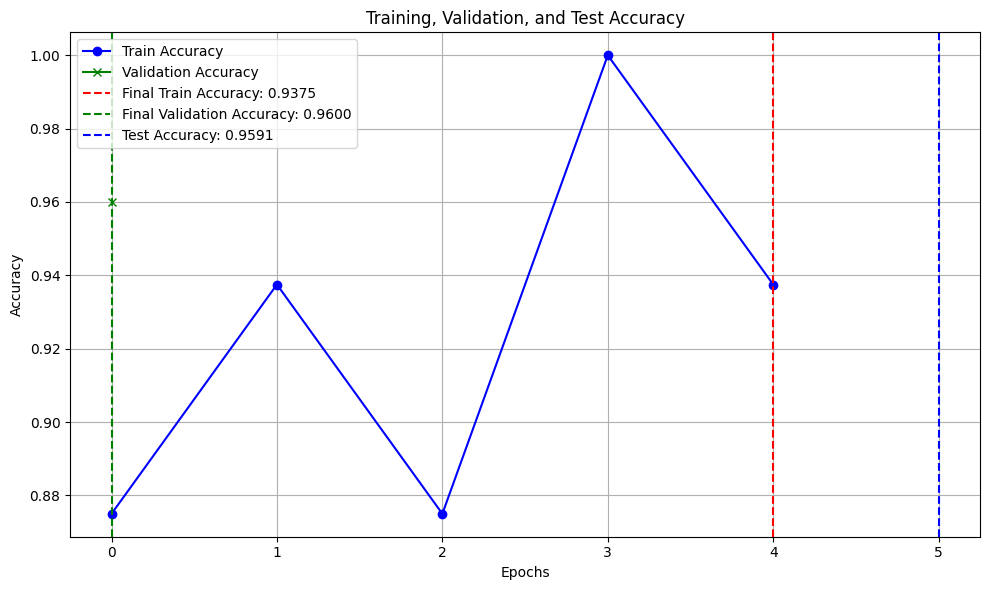

In [7]:
# you can change above plot accuracy code. It is sample code given.
plot_Accuracy(modelF)

# Part 2: Training a CNN network. (Points 24)

LeNet-5 is a bit dated, and doesn't actually represent modern deep learning practices. So, instead of training LeNet-5, let's train a simple "toy" convolutional neural network on the MNIST dataset. In In PyTorch Lightning, implement a convolutional neural network with the following layers:



*   A 2D convolution layer using (3×3) filter size, with 32 channels, and a ReLU activation.
* A 2D MaxPool layer with a (2×2) downsampling factor.
* Another 2D convolution layer using (3X3) filter size, with 32 channels, and a ReLU activation.
* Another 2D MaxPool layer with a (2×2) downsampling factor.
* A linear layer with a 128-dimensional output and a ReLU activation.
* A softmax layer with a 10-dimensional output and a softmax activation, which is the final layer of the network and maps to a distribution over the 10 classes of the MNIST dataset. (Make sure not to use two softmax functions: your cross-entropy loss may include its own implicit softmax!)

**Train this network** using
* a categorical cross-entropy loss with the following hyperparameters.
* Use the default initialization for your ML framework.
* Run stochastic gradient descent with momentum, using a step size of
α= 0.001, a momentum parameter of β=0.99, and a minibatch size of B=32
. (These are mostly just default values for neural network training, and not chosen with much intelligence or tuning.)
* Run for 5 epochs. (That is, 5 passes through the training data.)

Before training and after each epoch (i.e. a total of 6 times), measure the following:
*The training loss.
*The training error.
*The validation error.

This setting should achieve validation accuracy and test accuracy of around 99%, and a slightly higher training accuracy.

**Plot these observed values** (on a figure with iterations on the x-axis) and include the resulting figures in your report.

Also measure the amount of wall-clock time **bold text** it took to train this model, and include this measurement in your report.

**Create the CNN class (Points 12)**

In [8]:
class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define model layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define activation function
        self.relu = nn.ReLU()

        # loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize Accuracy metrics for multiclass classification
        self.train_acc = Accuracy(task='MULTICLASS', num_classes=10) # modify your code
        self.val_acc = Accuracy(task='MULTICLASS', num_classes=10)
        self.test_acc = Accuracy(task='MULTICLASS', num_classes=10)

        # Use these lists to store values for plotting
        self._train_loss = []
        self._train_acc = []
        self._val_loss = []
        self._val_acc = []
        self.test_loss = None
        self.test_acc_value = None

    def forward(self, x):
        #YOUR CODE
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # image flattening
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        # Training step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)  # Forward pass

        # Compute the cross-entropy loss
        loss = self.loss_fn(y_hat, y)

        # Calculate accuracy
        acc = self.train_acc(y_hat, y)

        # housekeeping
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'acc': acc}

    def on_train_epoch_end(self):
        # Collect training loss and accuracy at the end of the epoch: check trainer.callback_metrics
        avg_loss = self.trainer.callback_metrics.get('train_loss', None)
        avg_acc = self.trainer.callback_metrics.get('train_acc', None)

        if avg_loss is not None and avg_acc is not None:
            self._train_loss.append(avg_loss.item())
            self._train_acc.append(avg_acc.item())

    def validation_step(self, batch, batch_idx):
        # Validation step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        # Collect validation loss and accuracy at the end of the epoch
        avg_val_loss = self.trainer.callback_metrics.get('val_loss', None)
        avg_val_acc = self.trainer.callback_metrics.get('val_acc', None)

        if avg_val_loss is not None and avg_val_acc is not None:
            self._val_loss.append(avg_val_loss.item())
            self._val_acc.append(avg_val_acc.item())

    def test_step(self, batch, batch_idx):
        # Test step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)              # Correct usage of the test accuracy
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self):
        # Collect test loss and accuracy after testing
        avg_test_loss = self.trainer.callback_metrics.get('test_loss', None)
        avg_test_acc = self.trainer.callback_metrics.get('test_acc', None)

        if avg_test_loss is not None and avg_test_acc is not None:
            self.test_loss = avg_test_loss.item()
            self.test_acc_value = avg_test_acc.item()

    def configure_optimizers(self):
        # Use SGD optimizer with momentum and lr given above
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.99)
        return optimizer

**Training the model (Points 05)**

In [9]:
# Initialize the model
modelC = SimpleCNN()

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code


# Measure wall-clock time
start_time = time.time()

# Train the model
trainer.fit(modelC, train_loader)
trainer.validate(modelC, val_loader)


# Measure training time
end_time = time.time()
training_time = end_time - start_time

# Print the training time
print(f"Training took {training_time:.2f} seconds.")


# Evaluate on test set
# Test the model after training
trainer.test(modelC, test_loader)
print(f"Test accuracy: {test_result[0]['test_acc']:.4f}")

/usr/local/lib/python3.10/dist-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9871666431427002     │
│         val_loss          │    0.04602419212460518    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 130.69 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9887999892234802     │
│         test_loss         │    0.03475026413798332    │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9591


**Plot (Points 02)**

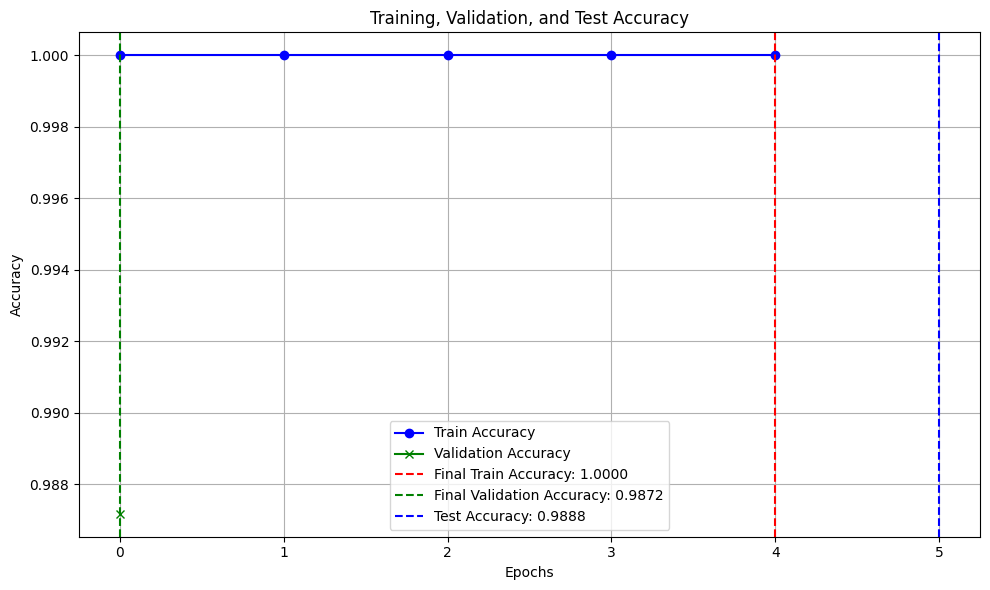

In [10]:
# After training is done
plot_Accuracy(modelC)

Write a Analysis: Write an analysis: Compare the performance of the Feedforward and CNN neural networks that you ran above. Write briefly. (Points 05)

Your answer.
- We can see that the number of parameters in CNN is almost double the number of parameters in FFNN.
- This increase is one of the reason why CNN performs slightly better compared to FFNN because CNN has more parameters compared to FFNN and hence it is a deeper network and can learn more complex features compared to a FFNN.
- This better learning of CNN can be seen through loss function and accuracy metrics. CNN has final loss of around 0.03 while FFNN has 0.14 which is 5x more. A similar trend can be seen in accuracy, CNN gives accuracy close to 99% while FFNN restricted its accuracy to just 96%

# Part 3: The Effect of Changing Mini-batch Size on Accuracy and Training Time (Points 13)

In this part, you will explore **how the mini-batch size affects** both the model's accuracy and the total wall-clock time of training using PyTorch Lightning.

Run the training process you ran above, now using B=8

you don't need to rewrite all the code. Instead, you can pass the batch size as a variable and reuse the same code.

Suggestion: Modify your data loader to accept a variable batch size, so you can easily switch between different batch sizes without rerunning the entire code.





**Modify Dataloader (Points 05)**

In [11]:
# Your Code

# Example: Modify the data loader to accept batch size dynamically
def get_data_loaders(batch_size):
    # your code
    train_loader = DataLoader(dataset=train_subset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


# Initialize the model
# Step 4: Example Usage - Train with Batch Size 8
batch_size = 8
model_dl = SimpleCNN()
train_loader8, val_loader8 ,test_loader8 = get_data_loaders(batch_size)  # Pass batch size dynamically

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code

# Train the model
start_time = time.time()
trainer.fit(model_dl, train_loader8)
trainer.validate(model_dl, val_loader8)
end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

# Test the model after training
trainer.test(model_dl, test_loader8)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | train
1 | conv2     | Conv2d             | 9.2 K  | train
2 | fc1       | Linear             | 200 K  | train
3 | fc2       | Linear             | 1.3 K  | train
4 | pool      | MaxPool2d          | 0      | train
5 | relu      | ReLU               | 0      | train
6 | loss_fn   | CrossEntropyLoss   | 0      | train
7 | train_acc | MulticlassAccuracy | 0      | train
8 | val_acc

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.987666666507721     │
│         val_loss          │    0.04903687909245491    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 315.80 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9882000088691711     │
│         test_loss         │   0.042620331048965454    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.042620331048965454, 'test_acc': 0.9882000088691711}]

**Plot (Points 02)**

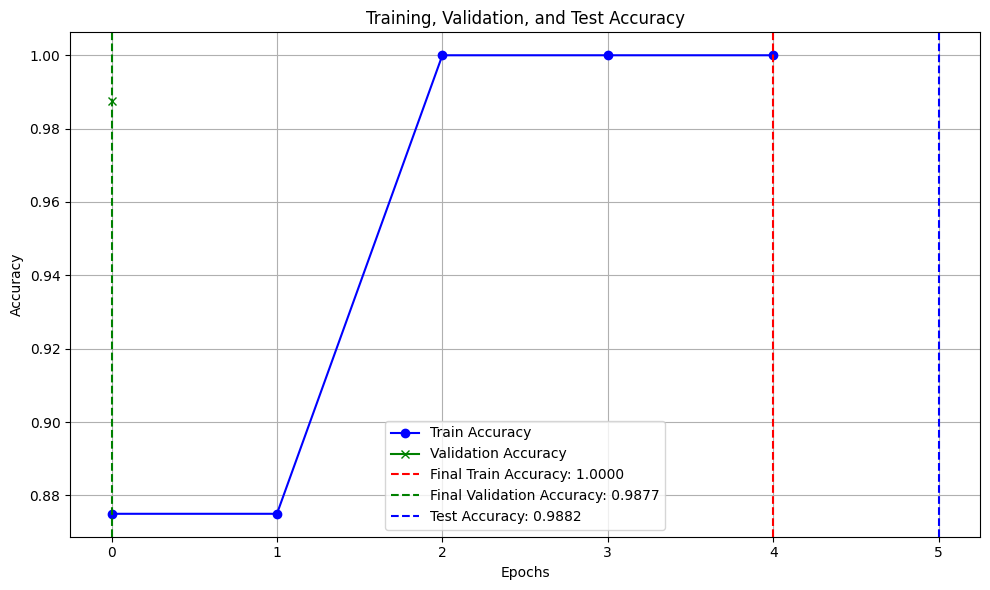

In [12]:
# After training is done
plot_Accuracy(model_dl)


Investigate how a smaller mini-batch size (B=8) influences the accuracy of the model after training. Write your conclusions based on following info:

*   Analyze how the change in mini-batch size affects the wall-clock time required
*   After running the experiment, compare the accuracy and wall-clock time of training for both mini-batch sizes (32 and 8).


Draw conclusions based on the results and analyze how the mini-batch size impacted the training process. (Points 06)

Your answer. Write Briefly.
- We can see that training time increased from 130sec to 316sec which is almost 2.5x, this is because we reduced the batch size and hence in each iteration a lesser no of data is being seen by the model which increases the no of iteration the model takes to see the entire dataset!! Hence leading to increase in training time.
- We can see the training accuracy for epoch 0 and epoch 1 is way less (around 88%) in this compared to when the model was trained on batch32 dataset (around 100%) this is because the model is not able to learn from the entire dataset, it was shown only a small part of the dataset in batch=8 model. But eventually in epoch 2 and epoch 3 the model picked up other important features from the dataset and reached close to 100% accuracy in batch=8 model...

# Part 4: The effect of momentum. (Points 12)

In this part, we will explore how using momentum affects training. Suppose that we were to use plain SGD without momentum (equivalent to setting β=0), and then run the same experiment (using the original minibatch size of B=32).

Suggestion:  Instead of re-running all the code, try passing the momentum parameter as an argument and adjust it to 0 in your training function. Modify above changes of class SimpleCNN if needed.

Instead of re-running all the code, pass the momentum value as an argument to your training function. This way, you can easily adjust the value of momentum and experiment with both β = 0.99 and β = 0 (no momentum) without rewriting the code.

Tip: Modify the SimpleCNN class if needed to accept the momentum parameter in the optimizer configuration.

**Modify to accept the momentum parameter (Points 05)**

In [13]:
# Your code
class SimpleCNN(pl.LightningModule):
    def __init__(self, momentum=0.99):
        super(SimpleCNN, self).__init__()
        self.momentum = momentum

        # Define model layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define activation function
        self.relu = nn.ReLU()

        # loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize Accuracy metrics for multiclass classification
        self.train_acc = Accuracy(task='MULTICLASS', num_classes=10) # modify your code
        self.val_acc = Accuracy(task='MULTICLASS', num_classes=10)
        self.test_acc = Accuracy(task='MULTICLASS', num_classes=10)

        # Use these lists to store values for plotting
        self._train_loss = []
        self._train_acc = []
        self._val_loss = []
        self._val_acc = []
        self.test_loss = None
        self.test_acc_value = None

    def forward(self, x):
        #YOUR CODE
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # image flattening
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        # Training step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)  # Forward pass

        # Compute the cross-entropy loss
        loss = self.loss_fn(y_hat, y)

        # Calculate accuracy
        acc = self.train_acc(y_hat, y)

        # housekeeping
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'acc': acc}

    def on_train_epoch_end(self):
        # Collect training loss and accuracy at the end of the epoch: check trainer.callback_metrics
        avg_loss = self.trainer.callback_metrics.get('train_loss', None)
        avg_acc = self.trainer.callback_metrics.get('train_acc', None)

        if avg_loss is not None and avg_acc is not None:
            self._train_loss.append(avg_loss.item())
            self._train_acc.append(avg_acc.item())

    def validation_step(self, batch, batch_idx):
        # Validation step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        # Collect validation loss and accuracy at the end of the epoch
        avg_val_loss = self.trainer.callback_metrics.get('val_loss', None)
        avg_val_acc = self.trainer.callback_metrics.get('val_acc', None)

        if avg_val_loss is not None and avg_val_acc is not None:
            self._val_loss.append(avg_val_loss.item())
            self._val_acc.append(avg_val_acc.item())

    def test_step(self, batch, batch_idx):
        # Test step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)              # Correct usage of the test accuracy
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self):
        # Collect test loss and accuracy after testing
        avg_test_loss = self.trainer.callback_metrics.get('test_loss', None)
        avg_test_acc = self.trainer.callback_metrics.get('test_acc', None)

        if avg_test_loss is not None and avg_test_acc is not None:
            self.test_loss = avg_test_loss.item()
            self.test_acc_value = avg_test_acc.item()

    def configure_optimizers(self):
        # Use SGD optimizer with momentum and lr given above
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=self.momentum)
        return optimizer

In [14]:
# your code
train_loader32, val_loader32 ,test_loader32 = get_data_loaders(32)  # Pass batch size dynamically
model_0mom = SimpleCNN(momentum = 0)

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code

# Train the model
start_time = time.time()
trainer.fit(model_0mom, train_loader32)
trainer.validate(model_0mom, val_loader32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

# Test the model after training
trainer.test(model_0mom, test_loader32)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | train
1 | conv2     | Conv2d             | 9.2 K  | train
2 | fc1       | Linear             | 200 K  | train
3 | fc2       | Linear             | 1.3 K  | train
4 | pool      | MaxPool2d          | 0      | train
5 | relu      | ReLU               | 0      | train
6 | loss_fn   | CrossEntropyLoss   | 0      | train
7 | train_acc | MulticlassAccuracy | 0      | train
8 | val_acc

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9136666655540466     │
│         val_loss          │    0.30645641684532166    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 127.98 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.920799970626831     │
│         test_loss         │    0.2801678478717804     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.2801678478717804, 'test_acc': 0.920799970626831}]

**Plot (Points 02)**

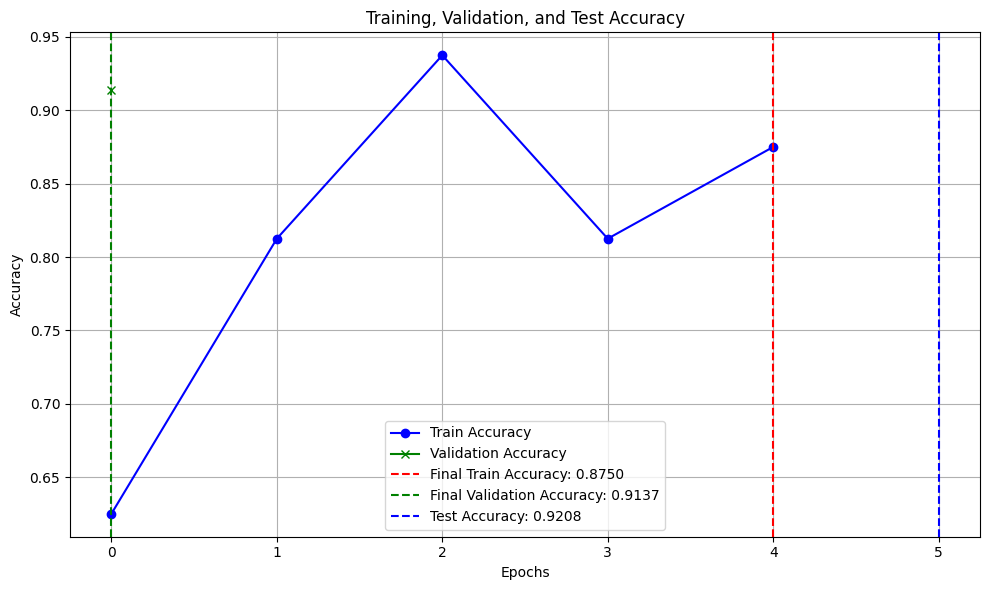

In [15]:
plot_Accuracy(model_0mom)

Write your analysis about how this change will affect the accuracy after training as well as how it will affect the wall-clock time of training. (Points 05)

Your answer (write briefly)

- We notice that the testing accuracy has droped significantly from 99% to 92% and testing loss has increased from 0.03 to 0.28 i.e. almost 10x. This is because SGD without momentum did not reach close to global minima instead it gave a suboptimal minima leading to a higher loss and lower accuracy!!

- We can see that the wall clock time has decreased from 130sec to 128sec i.e. model took lesser amount of time to train in this case since SGD without momentum is a faster optimizer compared to SGD with momentum. This is because SGD with momentum tries to reach the minima of the loss function by moving towards the correct direction by taking into account one additional information i.e. the previous step direction of descent as well as current step direction of descent. Thus making it a slightly slower optimizer compared with SGD without momentum.

# Part 5: The effect of network size. (Points 17)

In this part, we will explore how changing the network size affects training. Suppose that we were to use a network with more channels.

Specifically, suppose that we doubled the number of channels in each convolution layer of the **network from 32 to 64 ** and **doubled the output dimension of the linear layer from 128 to 256**.


**New Network and training and plot (Points 12)**

In [16]:
#Your code
class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super(SimpleCNN, self).__init__()

        # Define model layers
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define activation function
        self.relu = nn.ReLU()

        # loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize Accuracy metrics for multiclass classification
        self.train_acc = Accuracy(task='MULTICLASS', num_classes=10) # modify your code
        self.val_acc = Accuracy(task='MULTICLASS', num_classes=10)
        self.test_acc = Accuracy(task='MULTICLASS', num_classes=10)

        # Use these lists to store values for plotting
        self._train_loss = []
        self._train_acc = []
        self._val_loss = []
        self._val_acc = []
        self.test_loss = None
        self.test_acc_value = None

    def forward(self, x):
        #YOUR CODE
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # image flattening
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        # Training step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)  # Forward pass

        # Compute the cross-entropy loss
        loss = self.loss_fn(y_hat, y)

        # Calculate accuracy
        acc = self.train_acc(y_hat, y)

        # housekeeping
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'acc': acc}

    def on_train_epoch_end(self):
        # Collect training loss and accuracy at the end of the epoch: check trainer.callback_metrics
        avg_loss = self.trainer.callback_metrics.get('train_loss', None)
        avg_acc = self.trainer.callback_metrics.get('train_acc', None)

        if avg_loss is not None and avg_acc is not None:
            self._train_loss.append(avg_loss.item())
            self._train_acc.append(avg_acc.item())

    def validation_step(self, batch, batch_idx):
        # Validation step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        # Collect validation loss and accuracy at the end of the epoch
        avg_val_loss = self.trainer.callback_metrics.get('val_loss', None)
        avg_val_acc = self.trainer.callback_metrics.get('val_acc', None)

        if avg_val_loss is not None and avg_val_acc is not None:
            self._val_loss.append(avg_val_loss.item())
            self._val_acc.append(avg_val_acc.item())

    def test_step(self, batch, batch_idx):
        # Test step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)              # Correct usage of the test accuracy
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self):
        # Collect test loss and accuracy after testing
        avg_test_loss = self.trainer.callback_metrics.get('test_loss', None)
        avg_test_acc = self.trainer.callback_metrics.get('test_acc', None)

        if avg_test_loss is not None and avg_test_acc is not None:
            self.test_loss = avg_test_loss.item()
            self.test_acc_value = avg_test_acc.item()

    def configure_optimizers(self):
        # Use SGD optimizer with momentum and lr given above
        optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.99)
        return optimizer

In [17]:
# Initialize the model
model_dC = SimpleCNN()

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code

# training
start_time = time.time()
trainer.fit(model_dC, train_loader32)
trainer.validate(model_dC, val_loader32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

# Testing
trainer.test(model_dC, test_loader32)
print(f"Test accuracy: {test_result[0]['test_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 640    | train
1 | conv2     | Conv2d             | 36.9 K | train
2 | fc1       | Linear             | 803 K  | train
3 | fc2       | Linear             | 2.6 K  | train
4 | pool      | MaxPool2d          | 0      | train
5 | relu      | ReLU               | 0      | train
6 | loss_fn   | CrossEntropyLoss   | 0      | train
7 | train_acc | MulticlassAccuracy | 0      | train
8 | val_acc

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9884999990463257     │
│         val_loss          │    0.04649513214826584    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 129.56 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9878000020980835     │
│         test_loss         │   0.040481340140104294    │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9591


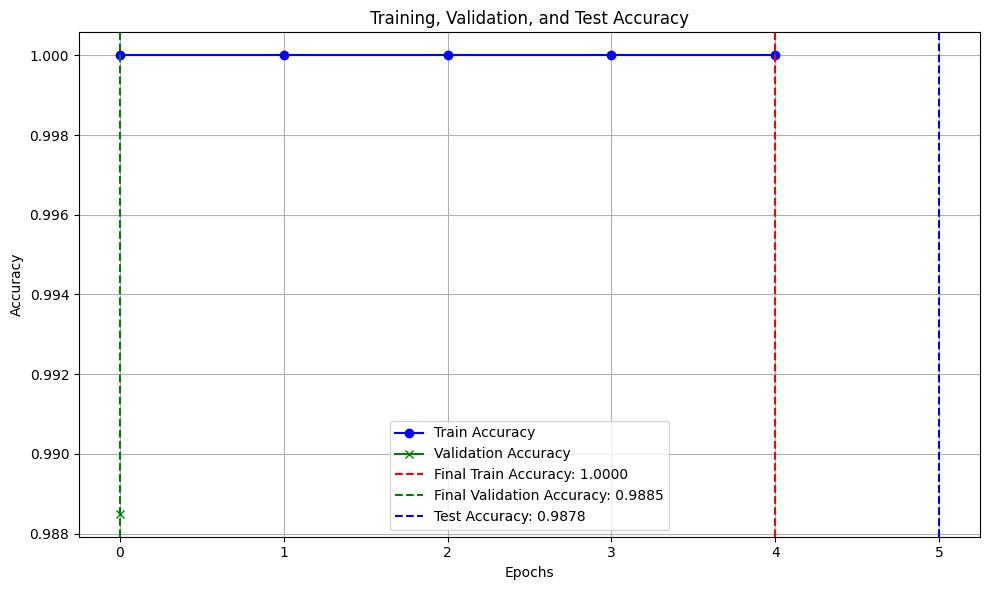

In [18]:
plot_Accuracy(model_dC)

Write your analysis about about how this change will affect the accuracy after training and also how this change will affect the wall-clock time of training. Your hypothesis should include a guess of by what factor you would expect the wall-clock time of training to increase or decrease due to this change. (Points 05)

Your answer (write briefly)
- We can see that no of parameter for the model has increased from 200k to 400k
- Since we have increase the no of channels in the model i.e. made the model more wider, it should increase the accuracy of the model.
- Since we have increased the model dimensions by almost a factor of 2, implies that the model is doing 2x more computations compared to previous model and hence the model wall clock time should increase by a factor of 2.


# BONUS Part: Testing other optimizers. (Points 06)

Above, we trained a network using momentum SGD. There are many other optimizers that are popular in machine learning. One of them is the Adam optimizer, but there are more.

Play with at least 2 more  optimizers. Run the training process you ran above in Part 2 (using the original minibatch size of B=32 and the original network architecture) and write down your analysis how this change will affect the accuracy after training and also how this change will affect the wall-clock time of training.

In [19]:
# your code
class SimpleCNN(pl.LightningModule):
    def __init__(self, optimizer):
        super(SimpleCNN, self).__init__()
        self.optimizer_name = optimizer

        # Define model layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

        # Define pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Define activation function
        self.relu = nn.ReLU()

        # loss function
        self.loss_fn = nn.CrossEntropyLoss()

        # Initialize Accuracy metrics for multiclass classification
        self.train_acc = Accuracy(task='MULTICLASS', num_classes=10) # modify your code
        self.val_acc = Accuracy(task='MULTICLASS', num_classes=10)
        self.test_acc = Accuracy(task='MULTICLASS', num_classes=10)

        # Use these lists to store values for plotting
        self._train_loss = []
        self._train_acc = []
        self._val_loss = []
        self._val_acc = []
        self.test_loss = None
        self.test_acc_value = None

    def forward(self, x):
        #YOUR CODE
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        # image flattening
        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def training_step(self, batch, batch_idx):
        # Training step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)  # Forward pass

        # Compute the cross-entropy loss
        loss = self.loss_fn(y_hat, y)

        # Calculate accuracy
        acc = self.train_acc(y_hat, y)

        # housekeeping
        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return {'loss': loss, 'acc': acc}

    def on_train_epoch_end(self):
        # Collect training loss and accuracy at the end of the epoch: check trainer.callback_metrics
        avg_loss = self.trainer.callback_metrics.get('train_loss', None)
        avg_acc = self.trainer.callback_metrics.get('train_acc', None)

        if avg_loss is not None and avg_acc is not None:
            self._train_loss.append(avg_loss.item())
            self._train_acc.append(avg_acc.item())

    def validation_step(self, batch, batch_idx):
        # Validation step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return {'val_loss': loss, 'val_acc': acc}

    def on_validation_epoch_end(self):
        # Collect validation loss and accuracy at the end of the epoch
        avg_val_loss = self.trainer.callback_metrics.get('val_loss', None)
        avg_val_acc = self.trainer.callback_metrics.get('val_acc', None)

        if avg_val_loss is not None and avg_val_acc is not None:
            self._val_loss.append(avg_val_loss.item())
            self._val_acc.append(avg_val_acc.item())

    def test_step(self, batch, batch_idx):
        # Test step: Compute loss and accuracy
        x, y = batch
        y_hat = self(x)
        loss = self.loss_fn(y_hat, y)
        acc = self.test_acc(y_hat, y)              # Correct usage of the test accuracy
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return {'test_loss': loss, 'test_acc': acc}

    def on_test_epoch_end(self):
        # Collect test loss and accuracy after testing
        avg_test_loss = self.trainer.callback_metrics.get('test_loss', None)
        avg_test_acc = self.trainer.callback_metrics.get('test_acc', None)

        if avg_test_loss is not None and avg_test_acc is not None:
            self.test_loss = avg_test_loss.item()
            self.test_acc_value = avg_test_acc.item()

    def configure_optimizers(self):

        if self.optimizer_name == 'adam':
            optimizer = optim.Adam(self.parameters(), lr=0.001)

        elif self.optimizer_name == 'sgd':
          optimizer = optim.SGD(self.parameters(), lr=0.001, momentum=0.99)

        elif self.optimizer_name == 'rmsprop':
            optimizer = optim.RMSprop(self.parameters(), lr=0.001, momentum=0.99)

        return optimizer

In [20]:
# Initialize the model
model_adam = SimpleCNN('adam')

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code

# training
start_time = time.time()
trainer.fit(model_adam, train_loader32)
trainer.validate(model_adam, val_loader32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

# Testing
trainer.test(model_adam, test_loader32)
print(f"Test accuracy: {test_result[0]['test_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | train
1 | conv2     | Conv2d             | 9.2 K  | train
2 | fc1       | Linear             | 200 K  | train
3 | fc2       | Linear             | 1.3 K  | train
4 | pool      | MaxPool2d          | 0      | train
5 | relu      | ReLU               | 0      | train
6 | loss_fn   | CrossEntropyLoss   | 0      | train
7 | train_acc | MulticlassAccuracy | 0      | train
8 | val_acc

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9884999990463257     │
│         val_loss          │    0.04529697075486183    │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 132.72 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │     0.989799976348877     │
│         test_loss         │   0.032062187790870667    │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9591


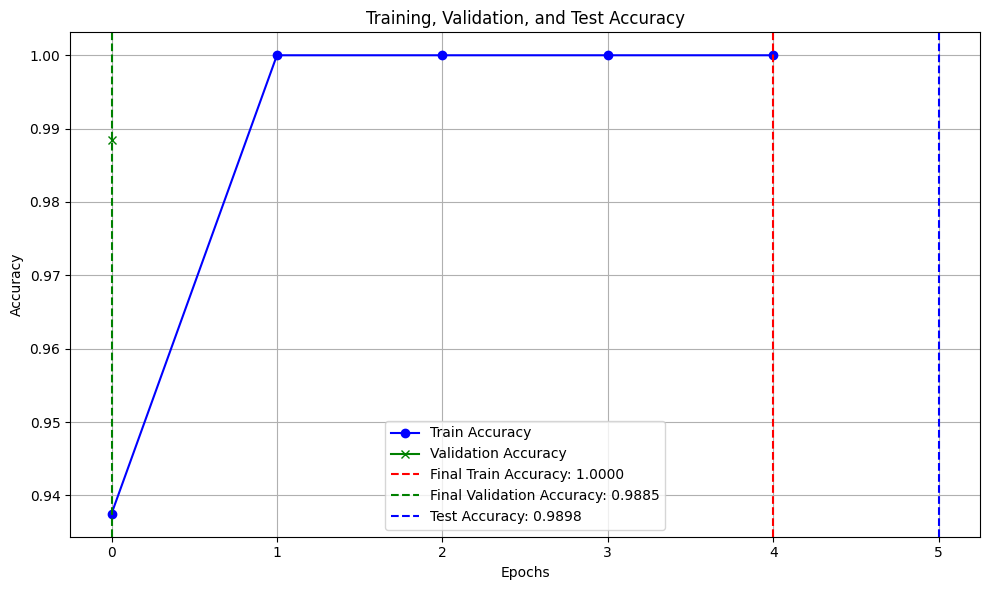

In [21]:
plot_Accuracy(model_adam)

In [22]:
# Initialize the model
model_rms = SimpleCNN('rmsprop')

# Initialize the Trainer
trainer = Trainer(accelerator="gpu", devices=1, min_epochs=1, max_epochs=5, precision=16) #your code

# training
start_time = time.time()
trainer.fit(model_rms, train_loader32)
trainer.validate(model_rms, val_loader32)
end_time = time.time()
training_time = end_time - start_time
print(f"Training took {training_time:.2f} seconds.")

# Testing
trainer.test(model_rms, test_loader32)
print(f"Test accuracy: {test_result[0]['test_acc']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | conv1     | Conv2d             | 320    | train
1 | conv2     | Conv2d             | 9.2 K  | train
2 | fc1       | Linear             | 200 K  | train
3 | fc2       | Linear             | 1.3 K  | train
4 | pool      | MaxPool2d          | 0      | train
5 | relu      | ReLU               | 0      | train
6 | loss_fn   | CrossEntropyLoss   | 0      | train
7 | train_acc | MulticlassAccuracy | 0      | train
8 | val_acc

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.11816667020320892    │
│         val_loss          │    2.3024561405181885     │
└───────────────────────────┴───────────────────────────┘

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Training took 134.29 seconds.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.11349999904632568    │
│         test_loss         │    2.3038244247436523     │
└───────────────────────────┴───────────────────────────┘

Test accuracy: 0.9591


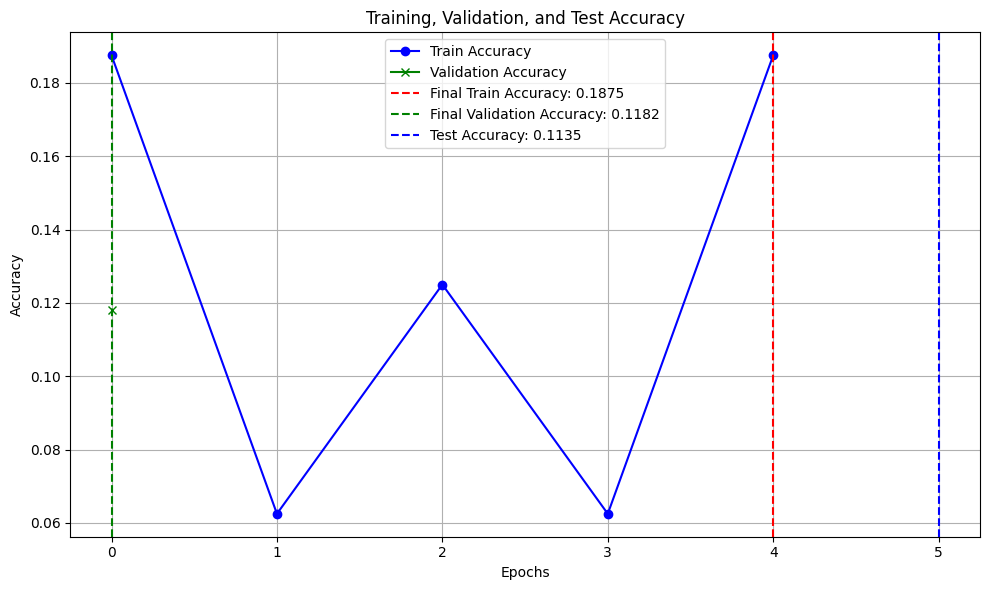

In [23]:
plot_Accuracy(model_rms)

Write your analysis

ADAM OPTIMIZER :   
- Since this is the best optimizer in terms of accuracy and speed, it should give the lease wall clock time and also perform the best i.e. give the highest accuracy. As we can see it took around 132sec and gave an accuracy of around 99% which are almost same numbers as what we saw for SGD with momentum. We can conclude that for this dataset both these optimizers perfrom equally well.

RMS PROP OPTIMIZER :   
- We can see that it took around 134sec which is slightly higher than what SGD with momentum took
- We also notice that the test accuracy has dropped significantly from 99% to 96%.
- Thus we can conclude that SGD with momentum is better optimizer than RMS Prop for this problem statement!!

# THE END